# Weights and Biases Callback
> Defines a fastai Callback for specifically tracking image-to-image translation experiments in Weights and Biases.

In [ ]:
#| default_exp tracking.wandb

In [ ]:
#| export
import wandb
from fastai.vision.all import *
from fastai.callback.wandb import *
from fastai.callback.wandb import _format_metadata, _format_config
from fastai.basics import *
from fastai.vision.gan import *
from upit.models.cyclegan import *
from upit.data.unpaired import *
from upit.train.cyclegan import *
from upit.metrics import *

In [ ]:
#| export
class SaveModelAtEndCallback(Callback):
    def __init__(self, fname='model', with_opt=False): store_attr()
    def _save(self, name): self.last_saved_path = self.learn.save(name, with_opt=self.with_opt)
    def after_fit(self, **kwargs): self._save(f'{self.fname}')
    @property
    def name(self): return "save_model"

In [ ]:
#| export
def log_dataset(main_path, folder_names=None, name=None, metadata={}, description='raw dataset'):
    "Log dataset folder"
    # Check if wandb.init has been called in case datasets are logged manually
    if wandb.run is None:
        raise ValueError('You must call wandb.init() before log_dataset()')
    path = Path(main_path)
    if not path.is_dir():
        raise f'path must be a valid directory: {path}'
    name = ifnone(name, path.name)
    _format_metadata(metadata)
    artifact_dataset = wandb.Artifact(name=name, type='dataset', metadata=metadata, description=description)
    # log everything in folder_names
    if not folder_names: folder_names = [p.name for p in path.ls() if p.is_dir()]
    for p in path.ls():
        if p.is_dir():
            if p.name in folder_names and p.name != 'models': artifact_dataset.add_dir(str(p.resolve()), name=p.name)
        else: artifact_dataset.add_file(str(p.resolve()))
    wandb.run.use_artifact(artifact_dataset)

In [ ]:
#| export
class UPITWandbCallback(Callback):
    "Saves model topology, losses & metrics"
    remove_on_fetch,order = True,Recorder.order+1
    # Record if watch has been called previously (even in another instance)
    _wandb_watch_called = False

    def __init__(self, log="gradients", log_preds=True, log_model=True, log_dataset=False, folder_names=None, dataset_name=None, valid_dl=None, n_preds=36, seed=12345, reorder=True):
        # Check if wandb.init has been called
        if wandb.run is None:
            raise ValueError('You must call wandb.init() before WandbCallback()')
        # W&B log step
        self._wandb_step = wandb.run.step - 1  # -1 except if the run has previously logged data (incremented at each batch)
        self._wandb_epoch = 0 if not(wandb.run.step) else math.ceil(wandb.run.summary['epoch']) # continue to next epoch
        store_attr()

    def before_fit(self):
        "Call watch method to log model topology, gradients & weights"
        self.run = not hasattr(self.learn, 'lr_finder') and not hasattr(self, "gather_preds") and rank_distrib()==0
        if not self.run: return

        # Log config parameters
        log_config = self.learn.gather_args()
        _format_config(log_config)
        try:
            wandb.config.update(log_config, allow_val_change=True)
        except Exception as e:
            print(f'WandbCallback could not log config parameters -> {e}')

        if not WandbCallback._wandb_watch_called:
            WandbCallback._wandb_watch_called = True
            # Logs model topology and optionally gradients and weights
            wandb.watch(self.learn.model, log=self.log)

       
        # log dataset
        assert isinstance(self.log_dataset, (str, Path, bool)), 'log_dataset must be a path or a boolean'
        if self.log_dataset is True:
            if Path(self.dls.path) == Path('.'):
                print('WandbCallback could not retrieve the dataset path, please provide it explicitly to "log_dataset"')
                self.log_dataset = False
            else:
                self.log_dataset = self.dls.path
        
        if self.log_dataset:
            self.log_dataset = Path(self.log_dataset)
            assert self.log_dataset.is_dir(), f'log_dataset must be a valid directory: {self.log_dataset}'
            metadata = {'path relative to learner': os.path.relpath(self.log_dataset, self.learn.path)}
            if self.folder_names:
                assert isinstance(self.folder_names, list), 'folder_names must be a list of folder names as strings'
                for name in self.folder_names: assert isinstance(name, str), 'the elements of folder_names must be strings'
            log_dataset(main_path=self.log_dataset, folder_names=self.folder_names, name=self.dataset_name, metadata=metadata)


        # log model
        if self.log_model and not hasattr(self, 'save_model'):
            print('Adding SaveModelAtEndCallback()')
            self.learn.add_cb(SaveModelAtEndCallback())
            self.add_save_model = True
        else: self.add_save_model = False

        if self.log_preds:
            try:
                if not self.valid_dl:
                    if not len(self.dls.valid_ds):
                        print('Saving training set predictions')
                        #Initializes the batch watched
                        wandbRandom = random.Random(self.seed)  # For repeatability
                        self.n_preds = min(self.n_preds, len(self.dls.train_ds))
                        idxs = wandbRandom.sample(range(len(self.dls.train_ds)), self.n_preds)
                        test_items = [getattr(self.dls.train_ds.items, 'iloc', self.dls.train_ds.items)[i] for i in idxs]
                        self.preds_dl = self.dls.test_dl(test_items, with_labels=True)
                        
                else: self.preds_dl = self.valid_dl
                self.learn.add_cb(FetchPredsCallback(dl=self.preds_dl, with_input=True, with_decoded=True, reorder=self.reorder))
            except Exception as e:
                self.log_preds = False
                print(f'WandbCallback was not able to prepare a DataLoader for logging prediction samples -> {e}')

    def after_batch(self):
        "Log hyper-parameters and training loss"
        if self.training:
            self._wandb_step += 1
            self._wandb_epoch += 1/self.n_iter
            hypers = {f'{k}_{i}':v for i,h in enumerate(self.opt.hypers) for k,v in h.items()}

            wandb.log({'epoch': self._wandb_epoch, 'train_loss': float(to_detach(self.smooth_loss.clone())), 
                       'raw_loss': float(to_detach(self.loss.clone())), **hypers}, step=self._wandb_step)

    def log_predictions(self, preds):
        raise NotImplementedError("To be implemented")

    def after_epoch(self):
        "Log validation loss and custom metrics & log prediction samples"
        # Correct any epoch rounding error and overwrite value
        self._wandb_epoch = round(self._wandb_epoch)
        wandb.log({'epoch': self._wandb_epoch}, step=self._wandb_step)
        # Log sample predictions
        if self.log_preds:
            try:
                self.log_predictions(self.learn.fetch_preds.preds)
            except Exception as e:
                self.log_preds = False
                print(f'WandbCallback was not able to get prediction samples -> {e}')
        wandb.log({n:s for n,s in zip(self.recorder.metric_names, self.recorder.log) if n not in ['train_loss', 'epoch', 'time']}, step=self._wandb_step)

    def after_fit(self):
        if self.log_model:
            if self.save_model.last_saved_path is None:
                print('WandbCallback could not retrieve a model to upload')
            else:
                metadata = {n:s for n,s in zip(self.recorder.metric_names, self.recorder.log) if n not in ['train_loss', 'epoch', 'time']}
                log_model(self.save_model.last_saved_path, metadata=metadata)
        self.run = True
        self.learn.remove_cb(FetchPredsCallback)
        self.learn.remove_cb(SaveModelAtEndCallback)
        wandb.log({})  # ensure sync of last step
        self._wandb_step += 1

In [ ]:
import tempfile

In [ ]:
#| cuda
horse2zebra = untar_data('https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip')
folders = horse2zebra.ls().sorted()
trainA_path = folders[2]
trainB_path = folders[3]
testA_path = folders[0]
testB_path = folders[1]
dls = get_dls(trainA_path, trainB_path, num_A=100, num_B=100, load_size=286)

#os.environ['WANDB_MODE'] = 'dryrun' # run offline
wandb.init()
cycle_gan = CycleGAN(3,3,64)
learn = cycle_learner(dls, cycle_gan,opt_func=partial(Adam,mom=0.5,sqr_mom=0.999),
                    cbs=[UPITWandbCallback(log_preds=True, log_model=True, log_dataset=horse2zebra, folder_names=[trainA_path.name,trainB_path.name])],
                    metrics=[FrechetInceptionDistance()])

learn.fit_flat_lin(1,1,2e-4)
wandb.finish()

wandb: Currently logged in as: tmabraham. Use `wandb login --relogin` to force relogin


wandb: Adding directory to artifact (/home/tmabraham/.fastai/data/horse2zebra/trainA)... 

Could not gather input dimensions


Done. 0.3s
wandb: Adding directory to artifact (/home/tmabraham/.fastai/data/horse2zebra/trainB)... Done. 0.1s


Adding SaveModelAtEndCallback()
Saving training set predictions


epoch,train_loss,id_loss_A,id_loss_B,gen_loss_A,gen_loss_B,cyc_loss_A,cyc_loss_B,D_A_loss,D_B_loss,frechet_inception_distance,time
0,9.819530,1.455294,1.471061,0.432893,0.477370,3.085176,3.139654,0.405227,0.405442,93.815806,00:17
1,8.568236,1.112963,1.203730,0.294678,0.299053,2.385156,2.604889,0.257748,0.254994,93.795887,00:16


/home/tmabraham/anaconda3/envs/UPIT/lib/python3.9/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


WandbCallback was not able to get prediction samples -> To be implemented


D_A_loss,█▁
D_B_loss,█▁
cyc_loss_A,█▁
cyc_loss_B,█▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
frechet_inception_distance,█▁
gen_loss_A,█▁
gen_loss_B,█▁
id_loss_A,█▁
id_loss_B,█▁


In [ ]:
#| cuda
b = dls.one_batch()
_,_,preds = learn.get_preds(dl=[b], with_decoded=True)

Text(0.5, 0.98, 'Predictions')

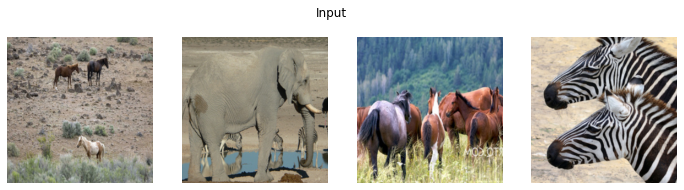

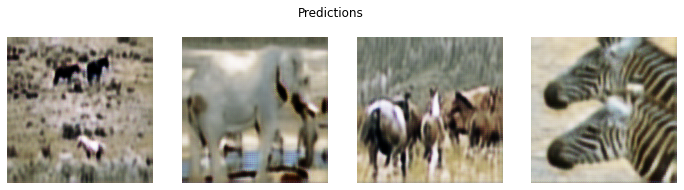

In [ ]:
#| cuda
dls.show_batch((b[0], b[1]), max_n=2, show=True)
plt.suptitle('Input')
dls.show_batch((preds[1],preds[0]), max_n=2, show=True)
plt.suptitle('Predictions')

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()